# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
os.chdir(r'C:\Users\Bazinga\AAIC\Assignments\AmazonDBSqlite')

In [3]:

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3  """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:20<00:00, 2587.12it/s]


In [24]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:44<00:00, 3470.85it/s]


In [26]:
preprocessed_summary[1500]

'would best canola oil left'

In [27]:
preprocessed_combinedText=[]
for i in range(0, len(preprocessed_reviews)):
    preprocessed_combinedText.append(preprocessed_reviews[i]+ ' ' + preprocessed_summary[i])

In [28]:
print(preprocessed_reviews[1500])
print('-----------------------------------')
print(preprocessed_summary[1500])
print('-----------------------------------')
print(preprocessed_combinedText[1500])

great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better
-----------------------------------
would best canola oil left
-----------------------------------
great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better would best canola oil left


In [29]:
print(len(preprocessed_reviews))
print(len(preprocessed_summary))
print(len(preprocessed_combinedText))

364171
364171
364171


In [30]:
final['CleanedText']=preprocessed_combinedText
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [31]:
final['Text'].shape

(364171,)

In [32]:
#Sorting based on Time
final['Time'] = pd.to_datetime(final['Time'], origin='unix', unit='s')
final = final.sort_values('Time')
print(final.shape)
print(final['Time'].head(1000))

(364171, 11)
138706   1999-10-08
138683   1999-10-25
417839   1999-12-02
346055   1999-12-06
417838   2000-01-03
            ...    
242710   2005-07-27
314365   2005-07-27
270097   2005-07-28
198583   2005-07-28
209305   2005-07-28
Name: Time, Length: 1000, dtype: datetime64[ns]


In [33]:
#Splitting Data into Train CV and Test
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(final['CleanedText'], final['Score'], test_size=.30, random_state=64)

In [34]:
print([i.shape for i in [X_train,X_test, Y_train, Y_test]])

[(254919,), (109252,), (254919,), (109252,)]


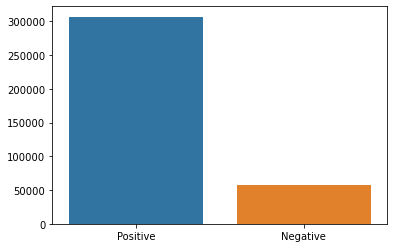

1    307061
0     57110
Name: Score, dtype: int64


In [35]:
sns.barplot(x=['Positive','Negative'], y=final['Score'].value_counts().values)
plt.show()

print(final['Score'].value_counts())

In [36]:
final_value_counts=final['Score'].value_counts()
positiveClassPercentage=((final_value_counts.sum() - final_value_counts[0])/final_value_counts.sum())*100
negativeClassPercentage=100-positiveClassPercentage
print('Percentage of Positive reviews- {} %'.format(round(positiveClassPercentage, 2)))
print('Percentage of Negative reviews- {} %'.format(round(negativeClassPercentage, 2)))

Percentage of Positive reviews- 84.32 %
Percentage of Negative reviews- 15.68 %


# [4] Featurization

## [4.1] BAG OF WORDS

In [37]:
#Compute BoW
from sklearn.preprocessing import normalize
countVector=CountVectorizer(min_df=5)
bow_train=countVector.fit_transform(X_train)

bow_test=countVector.transform(X_test)

print(list(map(type, [bow_train,bow_test])))
print('Shape of bow_train is: ', bow_train.shape)
print('Shape of bow_test is: ', bow_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (254919, 28115)
Shape of bow_test is:  (109252, 28115)


In [38]:
#Normalise BoW vectors
bow_train=normalize(X=bow_train, axis=1, norm='l2')
bow_test=normalize(X=bow_test,axis=1, norm='l2')

## [4.3] TF-IDF

In [39]:
#Compute tfidf
tfidfVector = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tfidf_train=tfidfVector.fit_transform(X_train)
tfidf_test=tfidfVector.transform(X_test)


print(list(map(type, [tfidf_train,tfidf_test])))
print('Shape of bow_train is: ', tfidf_train.shape)
print('Shape of bow_test is: ', tfidf_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (254919, 323281)
Shape of bow_test is:  (109252, 323281)


In [40]:
#Normalize tfidf vectors
tfidf_train=normalize(tfidf_train)
tfidf_test=normalize(tfidf_test)

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [41]:
# Train your own Word2Vec model using your own text corpus
# average Word2Vec for train, validation and test data 
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

#avgw2v for train data
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#avgw2v for test data
sent_vectors_test = []
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [11:36<00:00, 365.97it/s]


254919
50


100%|█████████████████████████████████████████████████████████████████████████| 109252/109252 [04:41<00:00, 388.06it/s]

109252
50


In [42]:
#Normalizing Avg w2v vectors
avgw2v_train=normalize(sent_vectors_train)
avgw2v_test=normalize(sent_vectors_test)

#### [4.4.1.2] TFIDF weighted W2v

In [43]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#TFIDF weighted W2V for train data
tfidf_sent_vectors_train = []
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#TFIDF weighted W2V for test data
list_of_sentance_test=[]
tfidf_sent_vectors_test = []
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 109252/109252 [05:12<00:00, 349.18it/s]


In [44]:
#normalize TF-IDF weighted Word2Vec 
tfidf_w2v_train=normalize(tfidf_sent_vectors_train)
tfidf_w2v_test=normalize(tfidf_sent_vectors_test)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [45]:
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score


def logisticRegressionGridSearchcv(trainData, trainLabels, regularization):
    #hyparameter c values
    C=dict(C=[1000,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001])

    #using LogisticRegression as model
    #set class_weight = "balanced" since target variables are imbalanced
    lr=LogisticRegression(penalty=regularization, solver='liblinear', class_weight='balanced')

    #Using GridSearchCV to find best Hyperparameter C
    clf=GridSearchCV(estimator=lr, param_grid=C, scoring= 'roc_auc',
                 n_jobs=-1, cv=5, verbose=1, return_train_score=True)
    clf.fit(trainData, trainLabels)

    optimum_C=clf.best_params_['C']
    df=pd.DataFrame(clf.cv_results_)[['param_C', 'mean_test_score', 'mean_train_score']]
    log_C=[math.log(x) for x in df['param_C']]
    print(df)
    print('\nOptimum C value is: ', optimum_C)

    #plotting Performance of AUC again various c values
    plt.close()
    plt.plot(log_C, df['mean_test_score'],'r-', label = 'Validation AUC')
    plt.plot(log_C, df['mean_train_score'],'b-', label = 'Train AUC')
    plt.xlabel('log(C)')
    plt.ylabel('AUC')
    plt.legend(loc='lower left')
    plt.title("Performance Model on Hyperparameter Alpha")
    plt.show()

    return optimum_C

In [46]:
def logisticRegressionModel(trainData, trainLabels, testData, testLabels, regularization, optimum_C):

    global lr_clf
    lr_clf=LogisticRegression(penalty=regularization, C=optimum_C, solver='liblinear', class_weight='balanced', n_jobs=-1) 
    lr_clf.fit(trainData, trainLabels)

    test_probs=lr_clf.predict_log_proba(testData)[:, 1]
    test_fpr, test_tpr, test_thresholds = roc_curve(testLabels, test_probs)

    train_probs=lr_clf.predict_log_proba(trainData)[:, 1]
    train_fpr, train_tpr, train_thresholds = roc_curve(trainLabels, train_probs)

    print('\nAUC score of the Optimum model is: ', round(roc_auc_score(testLabels, test_probs), 5))
    
    w = lr_clf.coef_
    w_sparcity=round((len(w[0])-np.count_nonzero(w))/len(w[0])*100, 4)
    print('Weight vector w is: {}'.format(w))
    print('Lenght of weight vector w is: {}'.format(len(w[0])))
    print('Non zero values in w are: {}'.format(np.count_nonzero(w)))
    print('Sparcity of Weight vector w is: {}%'.format(w_sparcity))

    #plot ROC AUC Curve
    plt.plot(train_fpr, train_tpr, linestyle='--', label='Train ROC')
    plt.plot(test_fpr, test_tpr, 'r-', label='Test ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    #Plot Confusion Matrix
    confusion_mat=confusion_matrix(testLabels, lr_clf.predict(testData))
    df_confusion_matrix=pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
    sns.heatmap(df_confusion_matrix, annot=True, fmt="d")
    plt.title("ROC AUC Curve")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.legend('right bottom')
    plt.show()
    
    return w

In [47]:
#get positve and negative important features
def getImportantFeatures(count_vector, clf):
    
    weights=clf.coef_.ravel()
    zipped_values=list(zip(count_vector.get_feature_names(), weights))
    sorted_values=sorted(zipped_values, key=lambda x: x[1], reverse=True)
    
    return sorted_values

In [48]:
def displayWordCould(df):
    wordCloud = WordCloud(collocations = False, background_color = 'white')\
                            .generate(' '.join(df))

    # Display the generated Word Cloud
    plt.figure(figsize=(8,8))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show('\n')

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.918029          0.995926
1      100         0.944348          0.995296
2       50         0.952992          0.994699
3       10         0.968311          0.990767
4        5         0.971542          0.987618
5        1         0.972873          0.978911
6      0.5         0.971214          0.975181
7      0.1         0.961633          0.963195
8     0.05         0.953606          0.954696
9     0.01         0.912750          0.913144
10   0.005         0.880918          0.881154
11   0.001         0.783000          0.783044

Optimum C value is:  1


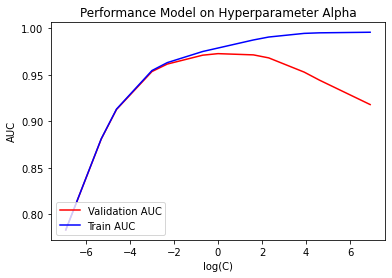

In [49]:
#Finding optimum C value
bow_l1_optimum_C=logisticRegressionGridSearchcv(bow_train, Y_train, 'l1')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>


AUC score of the Optimum model is:  0.97349
Weight vector w is: [[0. 0. 0. ... 0. 0. 0.]]
Lenght of weight vector w is: 28115
Non zero values in w are: 3248
Sparcity of Weight vector w is: 88.4474%


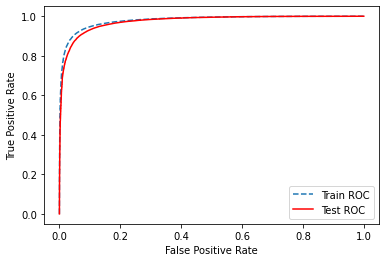

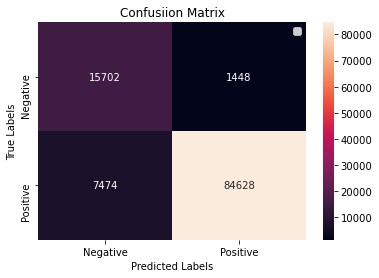

In [50]:
bow_l1_weight_vector=logisticRegressionModel(bow_train, Y_train, bow_test, Y_test, 'l1', bow_l1_optimum_C)

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.956343          0.994409
1      100         0.967658          0.991996
2       50         0.970100          0.990651
3       10         0.973295          0.986530
4        5         0.973714          0.984382
5        1         0.972400          0.978498
6      0.5         0.970679          0.975390
7      0.1         0.962845          0.965407
8     0.05         0.957079          0.959062
9     0.01         0.934000          0.935137
10   0.005         0.917961          0.918872
11   0.001         0.869819          0.870374

Optimum C value is:  5


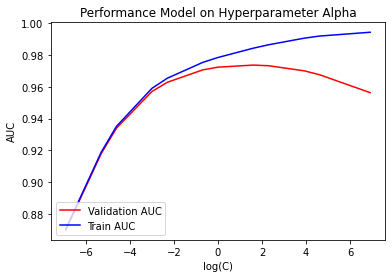

In [51]:
bow_l2_optimum_C=logisticRegressionGridSearchcv(bow_train, Y_train, 'l2')


AUC score of the Optimum model is:  0.97413
Weight vector w is: [[ 0.99633374  0.9799687   0.06487362 ... -0.42181194  0.06778334
   0.7592387 ]]
Lenght of weight vector w is: 28115
Non zero values in w are: 28115
Sparcity of Weight vector w is: 0.0%


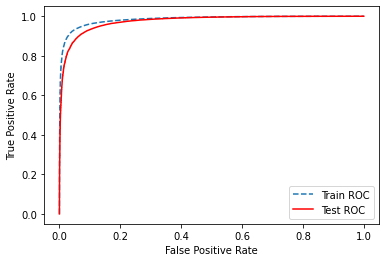

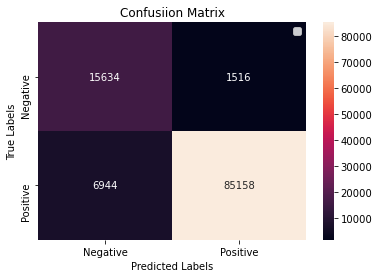

In [52]:
bow_l2_weight_vector=logisticRegressionModel(bow_train, Y_train, bow_test, Y_test, 'l2', bow_l2_optimum_C)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [53]:
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
lr_clf_=LogisticRegression(penalty='l1', C=5, solver='liblinear', class_weight='balanced', n_jobs=-1) 
lr_clf_.fit(bow_train, Y_train)
w=lr_clf_.coef_[0]
print(w.shape)
print(np.count_nonzero(w))

(28115,)
9434


In [54]:
e=0.0001
bow_train_noise=bow_train.data + e
print(bow_train_noise.shape)

(8658008,)


In [55]:
bow_train_noise=csr_matrix((bow_train_noise, bow_train.indices, bow_train.indptr), bow_train.shape)
print(bow_train_noise.shape)

(254919, 28115)


In [56]:
lr_clf_.fit(bow_train_noise, Y_train)
w_pert=lr_clf_.coef_[0]
print(w_pert.shape)
print(np.count_nonzero(w_pert))

(28115,)
9436


In [57]:
w=w+1e-6
w_pert=w_pert+1e-6

In [58]:
print(np.count_nonzero(w))
print(np.count_nonzero(w_pert))

28115
28115


In [59]:
delta = abs((w - w_pert)/(w))*100

l=[np.linspace(0, 100, 11), np.linspace(99, 100, 11), np.linspace(99, 100, 11)]
for i in l:
    for j in i:
        print("{}th Percentile value : {}".format(j, np.percentile(delta, j)))
    print('-'*50)   

0.0th Percentile value : 0.0
10.0th Percentile value : 0.0
20.0th Percentile value : 0.0
30.0th Percentile value : 0.0
40.0th Percentile value : 0.0
50.0th Percentile value : 0.0
60.0th Percentile value : 0.0
70.0th Percentile value : 0.014275641254655337
80.0th Percentile value : 0.05336001254811929
90.0th Percentile value : 0.11832103990959426
100.0th Percentile value : 1297650.0526954115
--------------------------------------------------
99.0th Percentile value : 1.7087425552577864
99.1th Percentile value : 1.9388894634611022
99.2th Percentile value : 2.178292684171101
99.3th Percentile value : 2.525494538505234
99.4th Percentile value : 2.805582933698582
99.5th Percentile value : 3.327629266096426
99.6th Percentile value : 4.3308750479186795
99.7th Percentile value : 5.76299795633457
99.8th Percentile value : 8.528942647036486
99.9th Percentile value : 17.261949514580902
100.0th Percentile value : 1297650.0526954115
--------------------------------------------------
99.0th Percenti

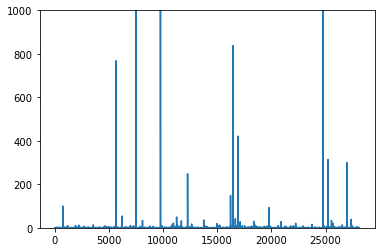

In [60]:
plt.plot(delta)
plt.ylim((0,1000))
plt.show()


In [61]:
percentageChange = delta.reshape(-1,1)
bow_features=countVector.get_feature_names()
len(bow_features)

28115

In [62]:
df=pd.DataFrame(data=bow_features, columns=['Features'])
df['Percentage Change']=percentageChange
df.iloc[100:,]

,Features,Percentage Change
100,accessibility,0.000000
101,accessible,0.112261
102,accessories,0.000000
103,accessory,0.020621
104,accident,0.036031
...,...,...
28110,zukes,0.146538
28111,zupreem,0.000000
28112,zwieback,0.000000
28113,zylitol,0.000000


In [63]:
# features with high change i.e, 99.5th percentile value)
df[df['Percentage Change'] > 0.3].sort_values(by='Percentage Change', axis=0, ascending=False)

,Features,Percentage Change
9748,fragrances,1.297650e+06
7501,driest,5.866392e+05
24745,tazo,1.334430e+05
16462,ninety,8.379704e+02
5636,creamiest,7.682264e+02
...,...,...
14357,lollipop,3.015314e-01
22710,smelt,3.013042e-01
5707,criollo,3.012990e-01
6068,dang,3.007245e-01


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

,Top Positive Features,Weights
1,pleasantly,14.583109
2,hooked,12.140192
3,yum,12.029180
4,excellent,11.302062
5,delicious,11.164525
6,awesome,11.131146
7,perfect,10.590570
8,beat,10.496446
9,fantastic,10.425249
10,skeptical,9.987378


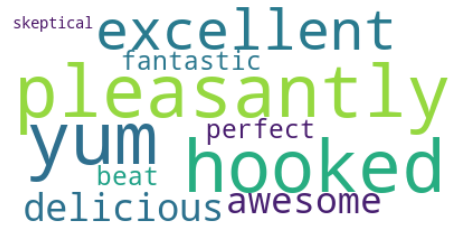

In [64]:
#Top 10 important features of positive class with BOW represntaion of vectors
from IPython.display import display
topPositiveFeatures=getImportantFeatures(countVector, lr_clf)[:10]
df=pd.DataFrame(data=topPositiveFeatures, columns=['Top Positive Features', 'Weights'])
df.index = np.arange(1, len(df) + 1)
display(df)

displayWordCould(df['Top Positive Features'])

,Top Negative Features,Weights
1,disappointing,-17.478872
2,worst,-16.167137
3,yuck,-14.813014
4,disappointment,-13.959874
5,terrible,-13.109333
6,awful,-12.587573
7,tasteless,-11.663114
8,mediocre,-11.643071
9,sounded,-11.283624


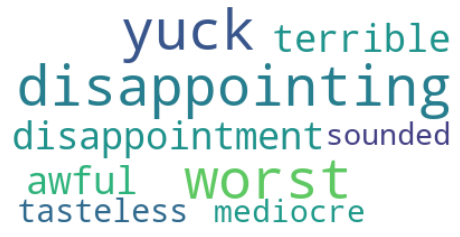

In [65]:
#Top 10 important features of negative class with BOW represntaion of vectors
topNegativeFeatures=getImportantFeatures(countVector, lr_clf)[:-10:-1]
df=pd.DataFrame(data=topNegativeFeatures, columns=['Top Negative Features', 'Weights'])
df.index = np.arange(1, len(df) + 1)
display(df)

displayWordCould(df['Top Negative Features'])

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.976388          1.000000
1      100         0.976730          1.000000
2       50         0.977113          1.000000
3       10         0.978824          0.999974
4        5         0.980210          0.998734
5        1         0.980190          0.987145
6      0.5         0.977752          0.981389
7      0.1         0.964619          0.965882
8     0.05         0.952795          0.953635
9     0.01         0.890189          0.890406
10   0.005         0.826877          0.827050
11   0.001         0.693922          0.693919

Optimum C value is:  5


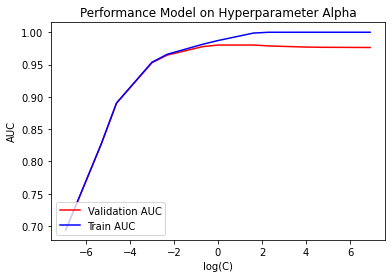

In [66]:
#Finding optimum C value
tfidf_l1_optimum_C=logisticRegressionGridSearchcv(tfidf_train, Y_train, 'l1')


AUC score of the Optimum model is:  0.98102
Weight vector w is: [[0. 0. 0. ... 0. 0. 0.]]
Lenght of weight vector w is: 323281
Non zero values in w are: 18482
Sparcity of Weight vector w is: 94.283%


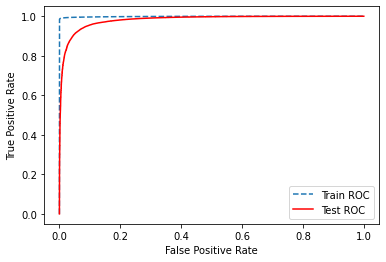

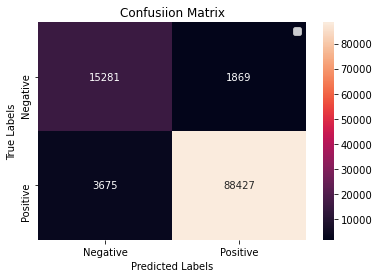

In [67]:
tfidf_l1_weight_vector=logisticRegressionModel(tfidf_train, Y_train, tfidf_test, Y_test, 'l1', tfidf_l1_optimum_C)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.980734          1.000000
1      100         0.981599          1.000000
2       50         0.981940          0.999998
3       10         0.982714          0.999685
4        5         0.982739          0.998865
5        1         0.981027          0.993269
6      0.5         0.979222          0.989242
7      0.1         0.971584          0.977342
8     0.05         0.966432          0.971002
9     0.01         0.950668          0.953634
10   0.005         0.944082          0.946699
11   0.001         0.935001          0.937253

Optimum C value is:  5


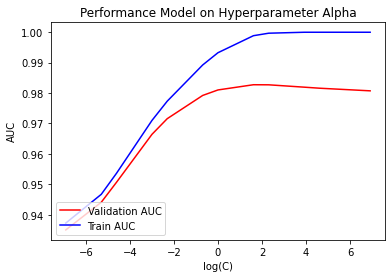

In [68]:
#Finding optimum C value
tfidf_l2_optimum_C=logisticRegressionGridSearchcv(tfidf_train, Y_train, 'l2')


AUC score of the Optimum model is:  0.98318
Weight vector w is: [[ 0.64287615  0.74301742  0.06548924 ... -0.40554318  0.61430381
   0.48095428]]
Lenght of weight vector w is: 323281
Non zero values in w are: 323281
Sparcity of Weight vector w is: 0.0%


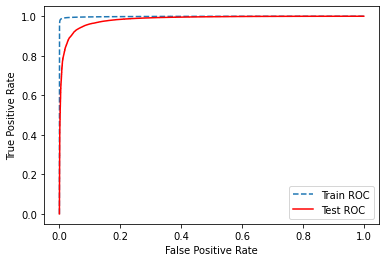

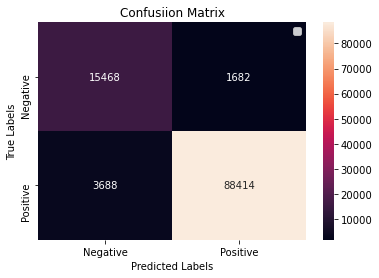

In [69]:
tfidf_l2_weight_vector=logisticRegressionModel(tfidf_train, Y_train, tfidf_test, Y_test, 'l2', tfidf_l2_optimum_C)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

,Top Positive Features,Weights
1,great,27.426176
2,delicious,22.820811
3,best,22.466712
4,good,20.628856
5,excellent,19.172328
6,perfect,18.259780
7,not disappointed,16.255285
8,not bad,16.049975
9,awesome,15.669576
10,love,15.207464


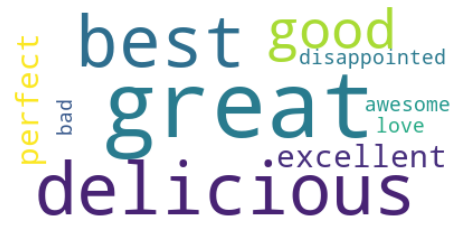

In [70]:
from IPython.display import display
topPositiveFeatures=getImportantFeatures(tfidfVector, lr_clf)[:10]
df=pd.DataFrame(data=topPositiveFeatures, columns=['Top Positive Features', 'Weights'])
df.index = np.arange(1, len(df) + 1)
display(df)

displayWordCould(df['Top Positive Features'])

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

,Top Negative Features,Weights
1,disappointed,-19.754503
2,not good,-18.683639
3,disappointing,-18.178584
4,not worth,-17.761904
5,worst,-17.569392
6,terrible,-16.113623
7,not,-15.381605
8,awful,-14.954029
9,two stars,-14.299908


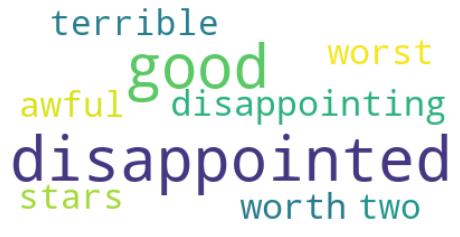

In [71]:
#Top 10 important features of negative class with BOW represntaion of vectors
topNegativeFeatures=getImportantFeatures(tfidfVector, lr_clf)[:-10:-1]
df=pd.DataFrame(data=topNegativeFeatures, columns=['Top Negative Features', 'Weights'])
df.index = np.arange(1, len(df) + 1)
display(df)

displayWordCould(df['Top Negative Features'])

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.946626          0.946774
1      100         0.946626          0.946774
2       50         0.946626          0.946773
3       10         0.946626          0.946773
4        5         0.946626          0.946773
5        1         0.946624          0.946771
6      0.5         0.946620          0.946766
7      0.1         0.946545          0.946685
8     0.05         0.946383          0.946509
9     0.01         0.944522          0.944628
10   0.005         0.941679          0.941773
11   0.001         0.918534          0.918609

Optimum C value is:  100


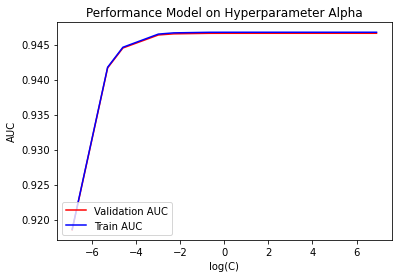

In [72]:
avgw2v_l1_optimum_C=logisticRegressionGridSearchcv(avgw2v_train, Y_train, 'l1')

In the above performance model plot, we can see that AUC score is constant for C value more than or equal to 1.
So, it is better to consider Optimum C as 1.


AUC score of the Optimum model is:  0.94489
Weight vector w is: [[ 0.7217934  -3.07336009 -2.20643517 -3.4791444   3.90402722 -0.11341407
  -0.56007762  1.53946256 -0.23550865 -0.63090775  0.49008013 -6.30027021
   1.82060038  6.06540646  6.1755727   0.06937532  1.43801778 -0.82332607
   4.77308191  0.89016729 -0.20650433  5.65255349 10.26798925  0.95971957
   3.9376767  -4.67250403  0.51484642  1.85049899  4.18212836  0.82029504
   0.73159649 -3.73541875  5.80103435  0.26178946 -5.87018489  0.64079902
  -2.17123774  4.77331691  1.41835325  1.83673811  7.68317398  2.53851163
  -0.26784243  1.66946594  4.47889571  0.96613433  4.45415602 -4.77548029
  -1.08310232  1.69917095]]
Lenght of weight vector w is: 50
Non zero values in w are: 50
Sparcity of Weight vector w is: 0.0%


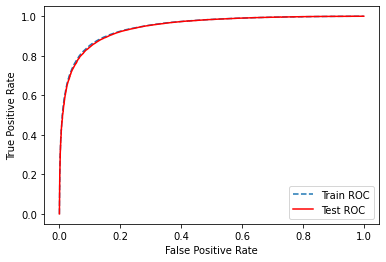

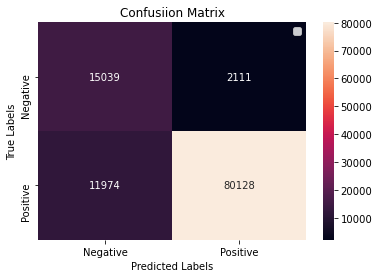

In [86]:
avgw2v_l1_weight_vector=logisticRegressionModel(avgw2v_train, Y_train, avgw2v_test, Y_test, 'l1', 1)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.946626          0.946774
1      100         0.946626          0.946774
2       50         0.946626          0.946773
3       10         0.946626          0.946773
4        5         0.946625          0.946771
5        1         0.946610          0.946755
6      0.5         0.946578          0.946721
7      0.1         0.946131          0.946261
8     0.05         0.945541          0.945662
9     0.01         0.942620          0.942710
10   0.005         0.940569          0.940645
11   0.001         0.934052          0.934103

Optimum C value is:  1000


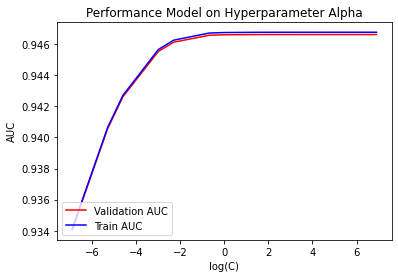

In [80]:
# Find optimum C
avgw2v_l2_optimum_C=logisticRegressionGridSearchcv(avgw2v_train, Y_train, 'l2')

In the above performance model plot, we can see that AUC score is constant for C value more than or equal to 1.
So, it is better to consider Optimum C as 1.


AUC score of the Optimum model is:  0.94489
Weight vector w is: [[ 0.82915354 -3.02492661 -2.16531284 -3.42899406  3.88638179 -0.10069448
  -0.61578959  1.34583986 -0.2473135  -0.63179845  0.46596261 -6.18481795
   1.83511004  5.94696536  6.11987192  0.09861889  1.35507798 -0.80943968
   4.75093326  0.92601016 -0.19391815  5.52644132 10.05665753  0.96273052
   3.81989303 -4.58829613  0.49329846  1.85785163  4.17896734  0.83719243
   0.72493588 -3.75691734  5.64371474  0.20122031 -5.62170502  0.57653584
  -2.23330429  4.71287579  1.3542683   1.73811836  7.46727076  2.48115874
  -0.20845809  1.65789996  4.36606328  0.98183434  4.45279131 -4.63511735
  -1.10102008  1.67692738]]
Lenght of weight vector w is: 50
Non zero values in w are: 50
Sparcity of Weight vector w is: 0.0%


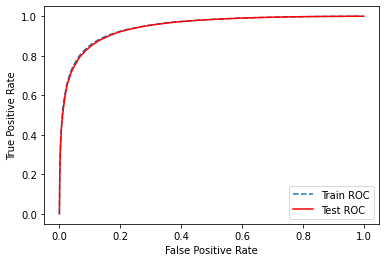

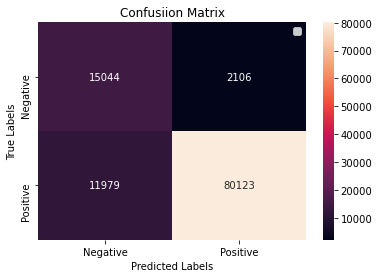

In [85]:
avgw2v_l2_weight_vector=logisticRegressionModel(avgw2v_train, Y_train, avgw2v_test, Y_test, 'l2', 1)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.890835          0.891068
1      100         0.890835          0.891068
2       50         0.890835          0.891068
3       10         0.890835          0.891068
4        5         0.890836          0.891068
5        1         0.890834          0.891066
6      0.5         0.890827          0.891059
7      0.1         0.890676          0.890905
8     0.05         0.890352          0.890581
9     0.01         0.887326          0.887554
10   0.005         0.884048          0.884262
11   0.001         0.844103          0.844239

Optimum C value is:  5


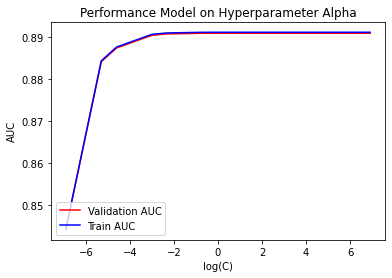

In [76]:
#Find optimum C
tfidf_w2v_l1_optimum_C=logisticRegressionGridSearchcv(tfidf_w2v_train, Y_train, 'l1')


AUC score of the Optimum model is:  0.94089
Weight vector w is: [[-0.43231457 -3.27878125 -1.42669604 -2.81189273  2.52288577  0.35332613
   0.57471604  4.57809677 -0.99160983 -1.39633243  1.51131106 -6.13513369
   0.59902209  4.8874279   5.22819745  0.40459371  1.61873135 -0.31214889
   3.08531083  0.94521846  0.67573759  5.54608324  9.31520819 -0.10451337
   2.80547792 -3.79624029  0.56321689  1.65956015  3.19734578 -0.58760947
   2.06824965 -1.92167666  6.32243236  0.36840186 -7.64272809  1.39196194
  -0.70303653  3.60877053  1.58329088  2.23397336  8.36481982  2.45674434
  -1.65001381  1.52338053  4.15590583  1.26893722  3.37343146 -5.16462747
  -0.1516383   1.92621233]]
Lenght of weight vector w is: 50
Non zero values in w are: 50
Sparcity of Weight vector w is: 0.0%


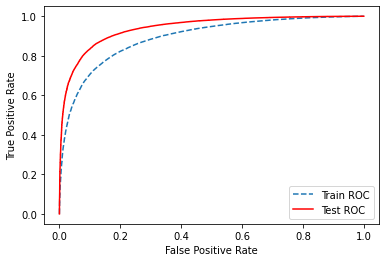

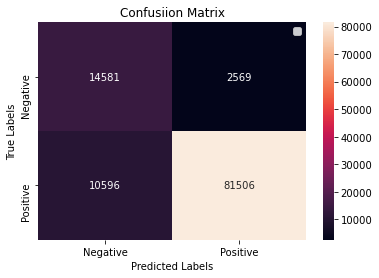

In [83]:
tfidf_w2v_l1_weight_vector=logisticRegressionModel(tfidf_w2v_train, Y_train, avgw2v_test, Y_test, 
                                                   'l1', tfidf_w2v_l1_optimum_C)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   param_C  mean_test_score  mean_train_score
0     1000         0.890835          0.891068
1      100         0.890835          0.891068
2       50         0.890835          0.891068
3       10         0.890835          0.891068
4        5         0.890835          0.891067
5        1         0.890798          0.891028
6      0.5         0.890705          0.890936
7      0.1         0.889806          0.890030
8     0.05         0.889062          0.889280
9     0.01         0.886325          0.886518
10   0.005         0.884123          0.884304
11   0.001         0.875735          0.875880

Optimum C value is:  10


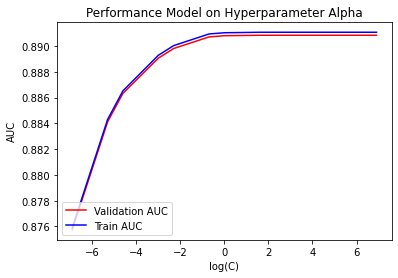

In [78]:
#Find optimum C
tfidf_w2v_l2_optimum_C=logisticRegressionGridSearchcv(tfidf_w2v_train, Y_train, 'l2')


AUC score of the Optimum model is:  0.88908
Weight vector w is: [[-0.19893236 -3.11810995 -1.36781392 -2.72473972  2.5308999   0.42557853
   0.39612085  4.04722515 -0.93095211 -1.37156404  1.42475531 -5.90906727
   0.66751881  4.72424234  5.24470004  0.46314071  1.54358675 -0.19113648
   3.17491899  1.04009474  0.71412616  5.26427804  8.90403009 -0.01786838
   2.59129695 -3.68748141  0.54909231  1.73727045  3.33060289 -0.51657371
   2.01856341 -2.06285567  6.001962    0.25497661 -7.19238355  1.15653371
  -0.91806227  3.50587795  1.43857435  2.02415952  7.85377103  2.37811335
  -1.41783128  1.4775223   3.92902358  1.27645295  3.42753437 -4.8388689
  -0.2720723   1.87350552]]
Lenght of weight vector w is: 50
Non zero values in w are: 50
Sparcity of Weight vector w is: 0.0%


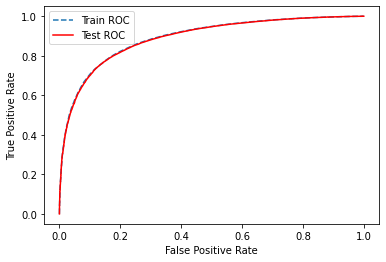

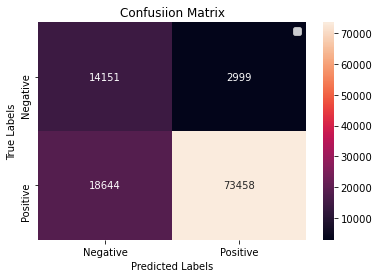

In [84]:
tfidf_w2v_l2_weight_vector=logisticRegressionModel(tfidf_w2v_train, Y_train, tfidf_w2v_test, Y_test,
                                                   'l2', tfidf_w2v_l2_optimum_C)

In [90]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Regularizer","Weight Vector Sparcity(%)", "Best hyperparameter(C)", "Test AUC Score"]
x.add_row(["bow", "l1", "88.44" , 1, 0.97349])
x.add_row(["bow", "l2", "0" , 5, 0.97413])
x.add_row(["tfidf","l1", "94.28" , 5, 0.98102])
x.add_row(["tfidf", "l2","0" , 5, 0.98318])
x.add_row(["avg_w2v", "l1", "0" , 1, 0.94489])
x.add_row(["avg_w2v", "l2", "0"  , 1, 0.94489])
x.add_row(["tfidf_avg_w2v","l1", "0" ,  5, 0.94089])
x.add_row(["tfidf_avg_w2v", "l2", "0"   , 10, 0.88908])
print(x)

+---------------+-------------+---------------------------+------------------------+----------------+
|   Vectorizer  | Regularizer | Weight Vector Sparcity(%) | Best hyperparameter(C) | Test AUC Score |
+---------------+-------------+---------------------------+------------------------+----------------+
|      bow      |      l1     |           88.44           |           1            |    0.97349     |
|      bow      |      l2     |             0             |           5            |    0.97413     |
|     tfidf     |      l1     |           94.28           |           5            |    0.98102     |
|     tfidf     |      l2     |             0             |           5            |    0.98318     |
|    avg_w2v    |      l1     |             0             |           1            |    0.94489     |
|    avg_w2v    |      l2     |             0             |           1            |    0.94489     |
| tfidf_avg_w2v |      l1     |             0             |           5           

# [6] Conclusions

- Model is built on entire dataset with 568,454 reviews
- The Feature Engineering technique of adding Review and Summary texts worked really good
- We can cleary see that bow and tfidf on l1 regularisation creates a Sparse matrix
- l2 regularization does not create Sparcity on any vectorizing models
- There is significant change in perturbated weight vector and weight vector after 99.7 percentile values.
- tfidf representation of l1 & l2 regularization yielded high AUC score about 98%
- Most of Top positive features and Top negative features are same in bow and tfidf vectors